TODO:  
- Normalize and denormalize data (Multilayer Perceptron)
- Adapt to multivariate scenarios (Multilayer Perceptron)
- Other types of missingness
- Other imputation methods

In [1]:
import copy
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas
import random
import sys
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers, activations
import warnings

# Handle version difference
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

data = pandas.read_csv('../Datasets/Gas_Furnace_Data.csv')
performances = {}

Helper Functions

In [2]:
def remove_random_values(data, values=10):
  to_return = copy.deepcopy(data)
  removed = []
  for i in range(values):
    ri = random.randint(data.index.start, data.index.stop - 1)
    while ri in removed:
      ri = random.randint(data.index.start, data.index.stop - 1)
    removed.append(ri)
    to_return.iloc[ri] = None
  return to_return

def get_missing_indices(data):
  return data.index[data.apply(np.isnan)]

def get_missing_indices_multiple_cols(data):
  ind = None
  for col in data.columns:
    if ind is None:
      ind = get_missing_indices(data[col])
    else:
      ind = ind.append(get_missing_indices(data[col]))
  to_return = list(set(ind))
  to_return.sort()
  return to_return

def plot_imputed(original_data, missing_indexes, imputed):
  plt.plot(np.arange(len(original_data)), original_data)
  plt.scatter(missing_indexes, imputed.iloc[missing_indexes])
  plt.show()

# MAE = (1 / n) * sum_{i = 1}^n abs(y_i - hat{y_i})
def get_mae_of_imputed(original_data, missing_indexes, imputed):
  original = original_data[missing_indexes]
  missing = imputed.iloc[missing_indexes]
  mae = 0
  for el in missing_indexes:
    mae += abs(original[el] - missing[el])
  return mae / len(original)

In [3]:
data_missing = remove_random_values(data['%C02'], values=20)
missing_indices = get_missing_indices(data_missing)

Univariate Imputation

First Method: Spline Interpolation

In [4]:
def spline_interpolation(data, order=2):
  return data.interpolate(method="spline", order=order)

In [5]:
get_missing_indices(data_missing)

Int64Index([  6,  12,  17,  19,  37,  67, 111, 154, 168, 173, 187, 210, 221,
            223, 241, 242, 270, 281, 292, 295],
           dtype='int64')

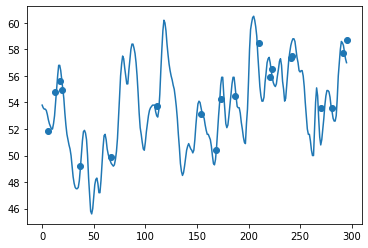

In [6]:
imputed_spline = spline_interpolation(data_missing)
plot_imputed(data['%C02'], missing_indices, imputed_spline)

In [7]:
mae_spline = get_mae_of_imputed(data['%C02'], missing_indices, imputed_spline)
print("MAE (Spline Interpolation):", mae_spline)
performances['spline'] = mae_spline

MAE (Spline Interpolation): 1.0012831603805759


Second Method: Mean of N Nearest Values Imputation

In [8]:
def get_nearest_n(data, ind, n):
  nearest = []
  for i in range(ind - 1, ind - n - 1, -1):
    if i in data.index and not math.isnan(data[i]):
      nearest.append(i)
  for i in range(ind + 1, ind + n + 1, 1):
    if i in data.index and not math.isnan(data[i]):
      nearest.append(i)
  return nearest

def nearest_mean_imputation(data, neighbourhood_size=2):
  to_return = copy.deepcopy(data)
  missing_indices = get_missing_indices(data)
  for el in missing_indices:
    nearest_indexes = get_nearest_n(data, el, neighbourhood_size)
    to_return[el] = np.mean(data.iloc[nearest_indexes])
  return to_return

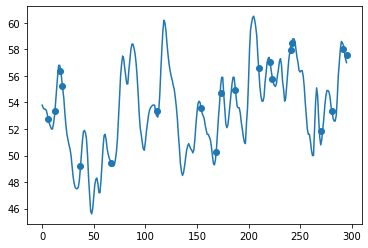

In [9]:
imputed_nearest_mean = nearest_mean_imputation(data_missing)
plot_imputed(data['%C02'], missing_indices, imputed_nearest_mean)

In [10]:
mae_nearest_mean = get_mae_of_imputed(data['%C02'], missing_indices, imputed_nearest_mean)
print("MAE (Nearest Mean Imputation):", mae_nearest_mean)
performances['nearest_mean'] = mae_nearest_mean

MAE (Nearest Mean Imputation): 0.305833333333333


Third Method: Multilayer Perceptron

In [11]:
def train_test_imputation_sets(data, ar_lag=1, order="forwards"):
  missing_data = copy.deepcopy(data)
  # Input and Output with no Missing Values 
  train_x = pandas.DataFrame()
  train_y = pandas.DataFrame()
  # Output with Missing Values
  test_x = pandas.DataFrame()
  test_y = pandas.DataFrame()
  # Input and Output with Missing Values
  both_x = pandas.DataFrame()
  both_y = pandas.DataFrame()
  y = missing_data.shift(-1)
  y.drop(y.tail(1).index, inplace=True)
  if ar_lag > 1:
    for i in range(1, ar_lag):
      to_append = missing_data.shift(i).fillna(0)
      for col in to_append.columns:
        to_append = to_append.rename(columns = {col: col + "-" + str(i)})
      missing_data = missing_data.join(to_append)
  missing_indices = get_missing_indices_multiple_cols(data)
  missing_indices_y = get_missing_indices_multiple_cols(y)
  for i in range(len(missing_data) - 1):
    # Input and Output have no Missing Values
    if i not in missing_indices and i not in missing_indices_y:
      train_x = train_x.append(missing_data.iloc[i])
      train_y = train_y.append(y.iloc[i])
    # Input has no Missing Values
    elif i not in missing_indices:
      test_x = test_x.append(missing_data.iloc[i])
      test_y = test_y.append(y.iloc[i])
    # Input and Output have Missing Values
    elif i in missing_indices and i in missing_indices_y:
      both_x = both_x.append(missing_data.iloc[i])
      both_y = both_y.append(y.iloc[i])
  return train_x, train_y, test_x, test_y, both_x, both_y

# TODO: Change to use training/test sets
def mlp_imputation(data, model, test_x, both_x, ar_lag=1):
  to_return = copy.deepcopy(data)
  for i in test_x.index:
    val = model.predict(to_return.loc[i].values.reshape((1, 1, to_return.loc[i].values.shape[0])))
    to_return.loc[i + 1] = val
  # Generates missing sets until there are none
  # A little bit bruteforce...
  while len(both_x) != 0 and len(test_x) != 0:
    _, _, test_x, _, both_x, _ = train_test_imputation_sets(to_return, ar_lag)
    for i in test_x.index:
      val = model.predict(to_return.loc[i].values.reshape((1, 1, to_return.loc[i].values.shape[0])))
      to_return.loc[i + 1] = val
  return to_return

In [12]:
ar_lag = 1
train_x, train_y, test_x, test_y, both_x, both_y = train_test_imputation_sets(pandas.DataFrame(data_missing), ar_lag=ar_lag)
train_x_re = np.reshape(train_x.values, (train_x.shape[0], 1, train_x.shape[1]))
test_x_re = np.reshape(test_x.values, (test_x.shape[0], 1, test_x.shape[1]))
train_y_re = train_y.values
test_y_re = test_y.values

In [13]:
keras.backend.clear_session()

'''
model = keras.models.Sequential([
  layers.Conv1D(filters=32, kernel_size=4, activation='relu', padding='same', input_shape=(train_x_re.shape[1], train_x_re.shape[2])),
  layers.Conv1D(filters=16, kernel_size=2, activation='relu', padding='same'),
  layers.Flatten(),
  layers.Dense(units=32, activation='relu'),
  layers.Dense(units=1)
])
'''

model = keras.models.Sequential([
    layers.Dense(10, activation="relu", input_shape=(train_x_re.shape[1], train_x_re.shape[2])),
    layers.Dense(10, activation="relu", input_shape=(train_x_re.shape[1], train_x_re.shape[2])),
    layers.Dense(train_y_re.shape[-1])
])

model.compile(loss='mae', optimizer='adam')
history = model.fit(train_x_re, train_y_re, epochs=100, shuffle=False)

Epoch 1/100
9/9 [==============================] - 2s 6ms/step - loss: 64.0068
Epoch 2/100
9/9 [==============================] - 0s 5ms/step - loss: 61.9971
Epoch 3/100
9/9 [==============================] - 0s 6ms/step - loss: 60.1429
Epoch 4/100
9/9 [==============================] - 0s 5ms/step - loss: 58.3078
Epoch 5/100
9/9 [==============================] - 0s 6ms/step - loss: 56.5993
Epoch 6/100
9/9 [==============================] - 0s 6ms/step - loss: 55.0893
Epoch 7/100
9/9 [==============================] - 0s 6ms/step - loss: 53.5843
Epoch 8/100
9/9 [==============================] - 0s 6ms/step - loss: 52.0758
Epoch 9/100
9/9 [==============================] - 0s 9ms/step - loss: 50.5405
Epoch 10/100
9/9 [==============================] - 0s 5ms/step - loss: 48.9518
Epoch 11/100
9/9 [==============================] - 0s 6ms/step - loss: 47.2818
Epoch 12/100
9/9 [==============================] - 0s 6ms/step - loss: 45.5015
Epoch 13/100
9/9 [==============================]

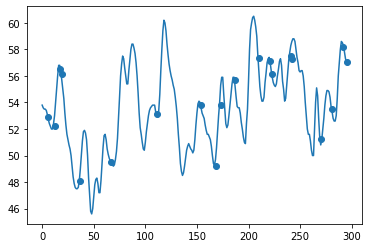

In [14]:
imputed_mlp = mlp_imputation(pandas.DataFrame(data_missing), model, test_x, both_x, ar_lag=ar_lag)
plot_imputed(data['%C02'], missing_indices, imputed_mlp)

In [15]:
mae_mlp = get_mae_of_imputed(data['%C02'], missing_indices, imputed_mlp[imputed_mlp.columns[0]])
print("MAE (Multilayer Perceptron):", mae_mlp)
performances['mlp'] = mae_mlp

MAE (Multilayer Perceptron): 0.4907409667968746


Fourth Method: missForest

In [16]:
# Method requires at least 2 variables
full_data_missing = copy.deepcopy(data)
full_data_missing['%C02'] = data_missing

In [17]:
imputer = MissForest()
imputed_mf = imputer.fit_transform(full_data_missing.values)[:, 1]

Iteration: 0
Iteration: 1
Iteration: 2


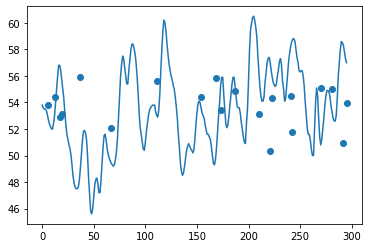

In [18]:
imputed_mf = pandas.DataFrame(imputed_mf)
plot_imputed(data['%C02'], missing_indices, imputed_mf)

In [19]:
mae_mf = get_mae_of_imputed(data['%C02'], missing_indices, imputed_mf[imputed_mf.columns[0]])
print("MAE (Multilayer Perceptron):", mae_mf)
performances['mf'] = mae_mf

MAE (Multilayer Perceptron): 3.4500483333333305
